# Вебинар 3. Коллаборативная фильтрация

Исчерпывающую информацию с теорией, кодом и примерами можно найти в [статье](https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/)

# 1. Матричная факторизация

Раскладываем user-item матрицу на 2: матрицу латентных факторов юзеров и матрицу латентных факторов товаров

- латентый фактор = эмбеддинг (embedding)    

<img src='mf.png'>

In [2]:
#(UхI) = (Uхk) * (kхI)

---

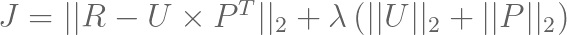

## Alternating Least Squares (ALS)

<img src="als_formula.png" >

$x_u^T$ - user embeddings  
$y_i$ - item embeddings  
$p_{ui}$ - 0/1. 1 - если в матрице user-item эдемент > 0 (было взаимодействие)  
$c_{ui}$ - Вес ошибки = элемент матрицы user-item  
$\lambda_x$, $\lambda_y$ - коэффициенты регуляризации  

**Алгоритм**  
ALS - лишь способ оптимизации (поиска коэффициентов в эмбеддингах):  

1. Фиксируем эмбеддинги юзеров $x_u^T$ --> легко посчитать производную по эмбеддингам товаров $y_i$
2. Обновляем эмбеддинги товаров (делаем шаг по антиградиенту = градиентный спуск)
3. Фиксируем эмбеддинги товаров $y_i$ --> легко посчитать производную по эмбеддингам юзеров $x_u^T$
4. Обновляем эмбеддинги юзеров (делаем шаг по антиградиенту = градиентный спуск)
5. Повторяем, пока процедура не сойдется

**Плюсы**
- Очень быстрый
- В продакшене можно зафиксировать на весь день эмбеддинги товаров (товары за день не меняются), 
    и в реал-тайм обновлять эмбеддинги юзеров при покупке
- Есть регуляризация $\lambda_x$, $\lambda_y$
- Есть веса ошибок $с_{u_i}$ - элементы матрицы user-item
- Библиотека implicit под капотом использует Cyton - очень быстро работает
- Predict для *всех* юзеров можно сделать просто перемножением 2-ух матриц - очень быстро
- Можно применять различные **взвешивания** матрицы: TF-IDF, BM25, ... . Это сильно улучшает качество

### 1. Базовое применение

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from metrics import precision_at_k, recall_at_k

In [4]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(10)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


In [5]:
item_features = pd.read_csv('product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [6]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [7]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [8]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [9]:
data_train.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [10]:
# Заведем фиктивный item_id

data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

/home/nikita/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
user_item_matrix

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [13]:
userid_to_id[1984]

1983

# ALS

In [14]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 29.2 s, sys: 17.9 s, total: 47.1 s
Wall time: 13 s


In [15]:
[id_to_itemid[rec[0]] for rec in recs]

[1133018, 1106523, 999999, 1082185, 5569230]

In [16]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [17]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: user 2min 37s, sys: 2min 5s, total: 4min 42s
Wall time: 1min 15s


0.1626836434867777

In [18]:
result.head(2)

,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 995242, 979707, 1105488, 1051211]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[910032, 1133018, 1106523, 938700, 965766]"


### Embeddings

In [19]:
model.item_factors.shape

(5001, 100)

In [20]:
pd.DataFrame(model.item_factors)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.002040,0.002315,0.000945,0.003730,0.003092,0.003583,0.002501,0.000805,0.003128,0.002810,...,0.002651,0.003652,0.003380,0.002063,0.003119,0.001481,0.003014,0.003493,0.001942,0.001395
1,0.000429,0.002230,-0.000636,0.005229,0.006043,0.007529,0.002820,-0.001796,0.002710,0.005888,...,-0.000779,0.009345,0.002442,-0.000642,0.005009,0.001809,0.001343,0.001530,0.004144,0.003757
2,0.000298,0.003452,-0.000432,0.001231,0.004184,0.003888,0.000817,0.002286,0.002027,0.002118,...,-0.000139,0.003414,0.004024,0.001078,0.003410,0.000107,0.004152,0.002619,0.001275,0.000807
3,0.002180,0.002547,0.000176,0.004332,0.001968,0.002311,0.000935,0.000022,0.002185,0.003210,...,0.001584,0.003277,0.001340,0.000155,0.002704,0.001752,0.004165,0.003057,0.003433,0.001084
4,0.002621,0.002552,0.000564,0.003010,0.002856,0.002789,0.002154,0.001370,0.002793,0.002540,...,0.002941,0.003087,0.003228,0.001938,0.002387,0.001247,0.002625,0.003337,0.002056,0.001719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,-0.003729,0.007691,0.010361,0.006786,0.008450,0.015457,0.002246,0.005160,0.001889,0.012121,...,-0.002338,0.002177,0.009776,0.008116,0.007607,0.004181,0.009649,0.006481,0.005732,0.006157
4997,0.009580,0.004880,-0.001815,0.006423,0.003492,0.009670,0.010749,0.005270,0.004815,0.005206,...,0.012452,0.008119,0.002780,0.007149,-0.002285,0.004647,0.007104,0.002663,0.003216,0.002655
4998,0.006998,0.005694,0.001197,0.006242,0.007001,0.002518,0.003488,0.003493,0.007729,0.000606,...,0.003813,0.006000,0.007326,-0.000730,0.005194,0.002632,0.004075,0.003819,0.003324,0.003513
4999,0.004499,0.004881,0.001993,0.005863,0.000317,0.008062,0.007294,0.002241,0.000355,0.006062,...,0.005088,0.009342,0.001464,0.008025,0.004754,0.005817,0.005026,0.006779,0.004388,0.007324


In [21]:
model.user_factors.shape

(2499, 100)

In [22]:
pd.DataFrame(model.user_factors)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-3.389435,-0.618803,1.336954,2.569565,5.932576,-5.216772,8.281100,4.856490,-3.661364,-9.153715,...,-5.448255,-4.107651,-0.891458,-1.949338,-4.280981,0.421640,-2.271080,-7.321725,6.956233,6.974032
1,-4.654256,3.025438,-0.027906,3.006806,-4.562694,-0.114651,7.136983,5.205957,0.924291,-1.046082,...,-7.268514,-4.843895,-3.937718,0.218091,-1.185352,-2.021557,2.386004,-2.755498,2.133056,3.756943
2,-4.485998,0.294977,1.370952,-0.557838,-5.862751,4.198915,1.641994,6.814697,2.959149,-0.701652,...,-4.353951,-1.778066,2.937758,4.020645,3.405861,5.115898,2.035033,-0.141493,4.664750,4.938824
3,-4.985702,2.043445,-5.351280,2.478656,-1.325007,1.664366,3.200163,3.310713,-0.721532,-3.012245,...,-4.039396,-4.124896,-3.342163,-4.477258,0.748316,-0.315925,1.847817,-2.151012,2.678373,0.017727
4,-1.573304,3.795666,-2.974566,3.673335,-4.161601,0.608247,1.637960,3.827393,-0.182846,-2.323209,...,-3.282023,-4.050768,-2.057132,-2.458235,1.810793,-1.247007,2.389510,0.109393,3.474522,2.112939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,-3.817861,-0.239428,0.746890,3.769372,-3.911683,-1.089841,4.595784,7.638681,-0.008133,-2.044059,...,-9.657342,-6.449348,-5.313602,4.494771,0.126138,2.101700,6.230580,-1.396806,-0.461440,5.761937
2495,-9.151954,8.075422,-2.399617,-0.215038,-0.950830,2.846328,-1.675241,8.118567,-2.116949,2.531726,...,-4.594838,-0.320711,-5.380519,4.325405,2.891069,-3.188484,0.470858,0.608783,-1.036096,5.582513
2496,-6.159471,4.660232,-0.645190,4.152369,-2.532733,2.405290,3.487813,4.445802,-1.390475,-3.871161,...,-6.191595,-4.549235,-3.465846,-2.776963,0.445750,0.218671,1.592998,0.745639,2.663196,1.005712
2497,-7.740340,6.042218,-2.544774,3.566805,-3.316587,-1.370130,1.891199,11.305768,2.501465,-6.733449,...,-4.065812,-0.881153,-1.206504,1.473506,4.506341,0.579300,-2.832102,-4.391985,1.271045,1.408142


Можно очень быстро посчитать предсказания, перемножив эти 2 матрицы

In [23]:
fast_recs = model.user_factors @ model.item_factors.T 
fast_recs.shape

(2499, 5001)

In [24]:
pd.DataFrame(fast_recs)

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
0,-0.000934,0.014632,-0.028868,-0.038502,0.006449,-0.000619,0.005074,0.277456,0.127199,-0.074849,...,0.162252,0.023487,0.260964,0.169266,0.361306,0.030338,-0.041545,0.089853,-0.042878,-0.109193
1,0.000869,0.024811,-0.018583,-0.005638,-0.005863,-0.005870,-0.002275,0.010849,0.072101,0.028912,...,0.016045,0.054291,0.020023,0.073321,0.110577,0.088205,0.093794,-0.090408,0.061151,-0.012930
2,-0.025090,-0.073365,-0.018539,-0.045217,-0.019289,-0.013334,-0.025451,0.085012,0.013376,0.122213,...,0.002307,-0.075849,0.215881,0.189671,0.156978,0.250538,0.122392,-0.009808,0.099480,-0.030416
3,0.011122,0.078107,0.040992,0.054428,0.008787,0.013124,-0.001872,0.157387,0.039770,0.022422,...,0.043217,0.038411,0.038633,-0.029221,0.029194,0.100006,0.072926,0.051140,0.018009,0.045836
4,0.001941,0.025120,-0.012674,0.031299,0.002533,-0.001915,-0.004798,0.014955,0.024810,0.008948,...,-0.001816,-0.002407,-0.006120,0.078087,0.047558,-0.045066,0.051108,-0.017740,0.028279,-0.014436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,0.005558,0.049629,0.058493,0.028319,0.007908,0.020983,-0.002798,0.095236,-0.059885,-0.051162,...,0.116769,-0.107133,0.159182,0.173368,0.247791,0.255404,0.065801,-0.039049,0.127311,0.170338
2495,0.038604,0.134976,0.093332,-0.009272,0.019379,0.030628,0.056574,0.092012,0.102749,0.240999,...,0.003368,0.364253,0.108081,0.124612,0.185163,0.273456,0.050932,0.060868,0.062599,0.132974
2496,0.053029,0.051330,-0.003689,0.022754,0.005063,-0.000293,0.013132,-0.106960,-0.071755,0.005906,...,0.084233,0.122397,0.076750,0.099786,0.096356,0.165355,0.080963,0.066922,0.057314,0.089499
2497,-0.009526,-0.019538,-0.040533,-0.041564,-0.014050,-0.017013,0.013896,0.107463,0.263608,0.070318,...,-0.020393,-0.064285,0.087855,-0.019621,0.038680,0.112160,0.191252,0.050680,0.069402,0.246004


In [26]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [27]:
model.item_factors.shape

(5001, 100)

In [28]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

In [29]:
print(category[:10])

['MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'MISC SALES TRAN', 'KIOSK-GAS', 'GROCERY', 'GROCERY', 'GROCERY']


/home/nikita/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


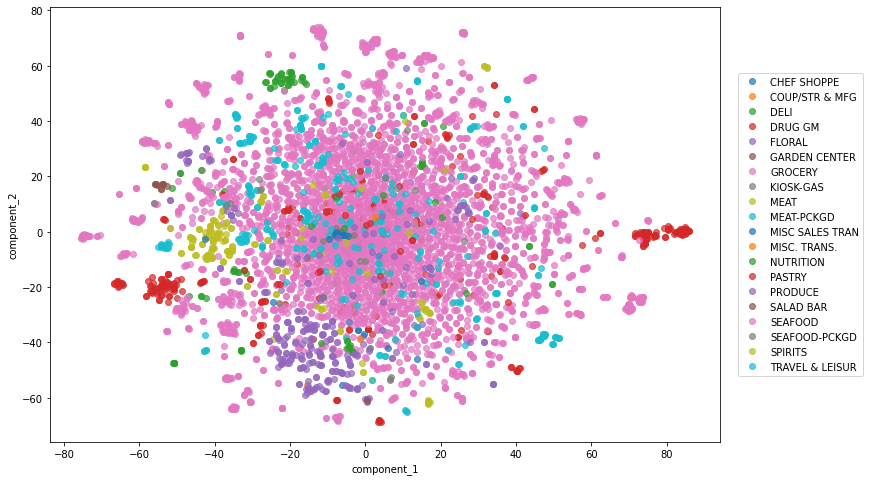

CPU times: user 1min 58s, sys: 2.69 s, total: 2min 1s
Wall time: 37.6 s


In [30]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne') # 5001 х 100  ---> 5001 x 2
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

Нарисуем все, кроме GROCERY

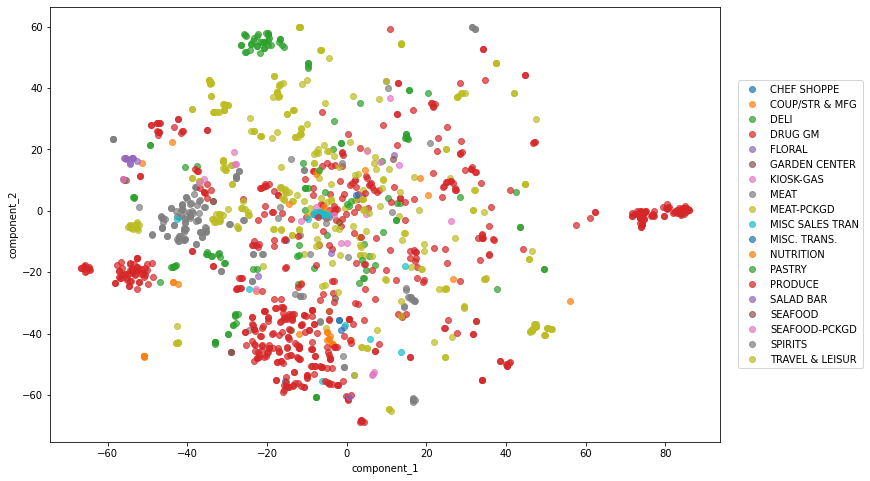

In [31]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'] != 'GROCERY'], labels='category')

Нарисуем несколько конкретных категорий

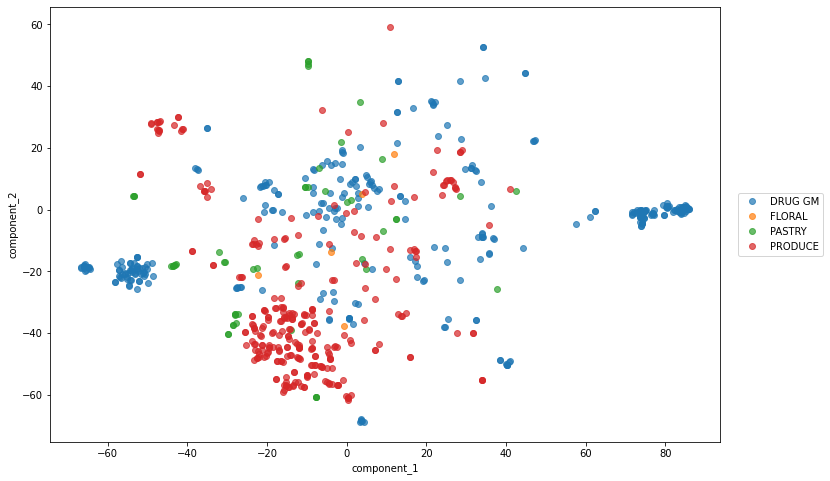

In [32]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

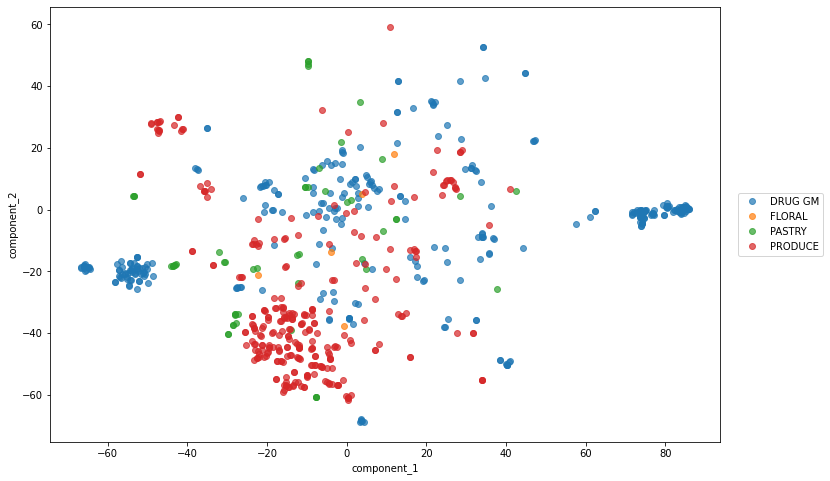

In [33]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

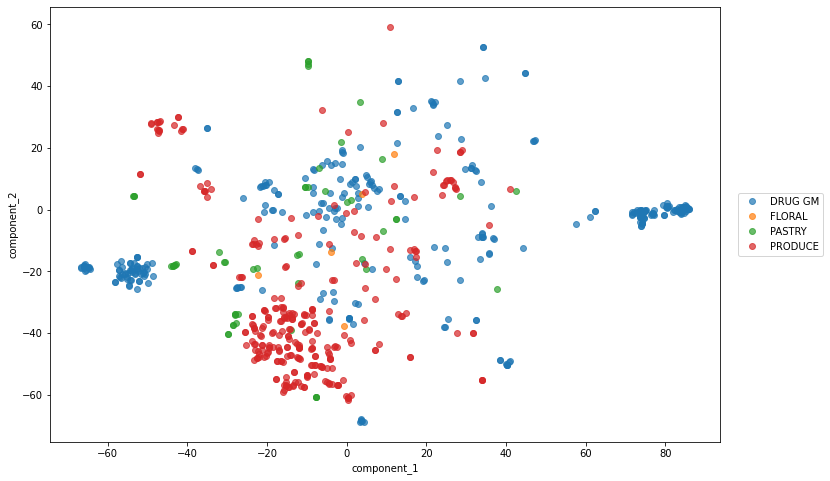

In [34]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

На самом деле, я бы сказал, что **результат средний**:
- Модель выучила похожесть только небольшой части товаров

In [35]:
item_emb_tsne.head(2)

,component_1,component_2,category
0,-7.123420,-1.197417,MISC SALES TRAN
1,-7.674127,1.206121,KIOSK-GAS


recommend_all делает перемножение, но еще и сортирует и выбирает топ-N

In [36]:
%%time
recommendations = model.recommend_all(N=5, 
                                      user_items=csr_matrix(user_item_matrix).tocsr(),
                                      filter_already_liked_items=True, 
                                      filter_items=None, 
                                      recalculate_user=True,
                                      show_progress=True,
                                      batch_size=500)

  0%|          | 0/2499 [00:00<?, ?it/s]

CPU times: user 2min 39s, sys: 2min 15s, total: 4min 54s
Wall time: 1min 16s


In [37]:
recommendations.shape

(2499, 5)

In [38]:
pd.DataFrame(recommendations)

,0,1,2,3,4
0,3031,192,3616,912,832
1,2148,2307,2927,215,3200
2,1242,1516,558,2765,3029
3,3408,4346,1801,3587,110
4,3408,2148,3133,2307,3587
...,...,...,...,...,...
2494,1801,2434,3557,1029,3995
2495,1419,1242,70,3322,650
2496,3587,4346,2148,558,3133
2497,2847,300,657,1486,1927


In [40]:
item_1 = model.item_factors[1]
item_2 = model.item_factors[2]

In [41]:
item_1.shape

(100,)

In [42]:
item_1

array([ 0.00042855,  0.0022305 , -0.00063571,  0.00522853,  0.00604275,
        0.00752905,  0.00281951, -0.00179616,  0.00270967,  0.00588776,
        0.00580631,  0.00348307,  0.00107088,  0.00072161,  0.00453277,
        0.00989932,  0.00259638,  0.00546128,  0.00852091,  0.00435642,
       -0.0007153 ,  0.00058709,  0.00598352,  0.00199767,  0.00606951,
        0.00095828,  0.00308081,  0.00175446,  0.00126115,  0.00110948,
        0.00564786, -0.00128709, -0.00170706,  0.00836693,  0.00598135,
        0.00613975,  0.00176237,  0.00365778,  0.00790632,  0.01052157,
        0.00602423,  0.00152149,  0.00603083,  0.00207965,  0.00110444,
        0.00492331,  0.00945339,  0.00363962, -0.00074136,  0.00312465,
        0.00331511,  0.00237167,  0.00536004,  0.0026772 , -0.00293317,
        0.0065264 ,  0.00062846,  0.00429301,  0.00133959,  0.00136124,
        0.00238365, -0.00207961,  0.00529409,  0.00557166,  0.00589995,
        0.00500226,  0.0034056 ,  0.0034646 ,  0.00465257, -0.00

*Посмотрите также / Похожие товары*

In [43]:
example_item_row_id = 3606

In [44]:
closest_items = [ id_to_itemid[row_id] for row_id, score in model.similar_items(example_item_row_id, N=5)]

In [45]:
item_features[item_features.item_id.isin(closest_items)]

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
8143,839040,942,GROCERY,National,CONDIMENTS/SAUCES,HOT MUSTARD/SPECIALTY MUSTAR,12 OZ
17055,917832,213,GROCERY,National,MEAT - SHELF STABLE,CHILI: CANNED,15 OZ
25270,990804,69,GROCERY,Private,VEGETABLES - SHELF STABLE,MUSHROOMS CND & GLASS,4.5 OZ
37579,1100265,69,GROCERY,Private,CHEESE,NATURAL CHEESE EXACT WT SLICES,10 OZ
41452,1135476,673,PRODUCE,National,BERRIES,STRAWBERRIES,1 LB


*Вашим друзьям нравится / Похожим пользователям нравится / ...*

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [46]:
model.similar_users(userid_to_id[10], N=5)

[(9, 1.0000001),
 (354, 0.9745565),
 (239, 0.9742911),
 (1627, 0.97116846),
 (1380, 0.9706659)]

### 2. TF-IDF взвешивание

In [47]:
user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [48]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 3min 3s, sys: 2min 23s, total: 5min 26s
Wall time: 1min 26s


0.16464250734573949

### 3. BM25 взвешивание

In [49]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

/home/nikita/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [51]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 3min 4s, sys: 2min 25s, total: 5min 29s
Wall time: 1min 26s


In [52]:
result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()

0.19108716944172383

In [53]:
result

,user_id,actual,als,als_tfidf,als_bm25
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 995242, 979707, 1105488, 1051211]","[5569374, 1033142, 1105488, 999999, 1025641]","[999999, 1082185, 995242, 934369, 1033142]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[910032, 1133018, 1106523, 938700, 965766]","[951590, 999999, 1133018, 1106523, 910032]","[999999, 951590, 1053690, 1133018, 1092026]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1007195, 866211, 1023720, 866227, 878996]","[1051516, 1007195, 1023720, 1024306, 878996]","[1082185, 1023720, 1024306, 878996, 999999]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1058997, 938700, 1126899, 999999, 1082185]","[999999, 1082185, 826249, 1106523, 1029743]","[999999, 1082185, 6944571, 1126899, 1058997]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[844179, 1068719, 913785, 1004906, 1044078]","[1053690, 965766, 844179, 938700, 1004906]","[999999, 883404, 1004906, 840361, 965766]"
...,...,...,...,...,...
2037,2496,[6534178],"[914190, 840361, 1013321, 1133018, 1006184]","[914190, 1133018, 847982, 5568729, 840361]","[914190, 999999, 840361, 1133018, 831628]"
2038,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[5569230, 826249, 5569845, 1098066, 951590]","[5569230, 5569471, 951590, 5585510, 854852]","[5569230, 957951, 999999, 995785, 981760]"
2039,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[999999, 862349, 1070820, 1053690, 1082185]","[999999, 1082185, 1070820, 862349, 995242]","[999999, 995242, 862349, 840361, 1070820]"
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[938700, 883404, 1004906, 862349, 5568378]","[929668, 1004906, 6534178, 1098066, 883404]","[999999, 826249, 1098066, 883404, 5569845]"


In [54]:
result.to_csv('predictions_mf.csv', index=False)  # mf - matrix factorization

## 4. Важно искать оптимальные параметры

- regularization, iterations
- factors
- Вес (элемент в матрице user-item)

-----

# Production

Начиная с этого вебинара, мы будем строить *базовое решение* для системы рекомендаций топ-N товаров. В финальном проекте вам нужно будет его сущесвтенно улучшить.  
  
**Ситуация**: Вы работает data scientist в крупном продуктовом российском ритейлере. Ваш конкурент сделал рекомендательную систему, и его продажи выросли. Ваш менеджмент тоже хочет увеличить продажи   
**Задача со слов менеджера**: Сделайте рекомендательную систему топ-10 товаров для рассылки по e-mail

**Ожидание:**
- Отправляем e-mail с топ-10 товарами, отсортированными по вероятности

**Реальность:**
- Чего хочет менеджер от рекомендательной системы? (рост показателя X на Y% за Z недель)
- По-хорошему надо бы предварительно посчитать потенциальный эффект от рекоммендательной системы (Оценки эффектов у менеджера и у вас могут сильно не совпадать: как правило, вы знаете про данные больше)
- А у нас вообще есть e-mail-ы пользователей? Для скольки %? Не устарели ли они?
- Будем ли использовать СМС и push-уведомления в приложении? Может, будем печатать рекомендации на чеке после оплаты на кассе?
- Как будет выглядеть e-mail? (решаем задачу топ-10 рекомендаций или ранжирования? И топ-10 ли?)
- Какие товары должны быть в e-mail? Есть ли какие-то ограничения (только акции и т п)?
- Сколько денег мы готовы потратить на привлечение 1 юзера? CAC - Customer Aquisition Cost. Обычно CAC = расходы на коммуникацию + расходы на скидки
- Cколько мы хотим зарабатывать с одного привлеченного юзера?
---
- А точно нужно сортировать по вероятности?
- Какую метрику использовать?
- Сколько раз в неделю отпрпавляем рассылку?
- В какое время отправляем рассылку?
- Будем отправлять одному юзеру много раз наши рекоммендации. Как добиться того, чтобы они хоть немного отличались?
- Нужно ли, чтобы в одной рассылке были *разные* товары? Как определить, что товары *разные*? Как добиться того, чтобы они были разными?
- И многое другое:)

**В итоге договорились, что:**
- Хотим повысить выручку минимум на 6% за 4 месяца. Будем повышать за счет роста Retention минимум на  3% и среднего чека минимум на 3%
- Топ-5 товаров, а не топ-10 (В e-mail 10 выглядят не красиво, в push и на чек больше 5 не влезает)
- Рассылаем в e-mail (5% клиентов) и push-уведомлении (20% клиентов), печатаем на чеке (все оффлайн клиенты)
- **3 товара с акцией** (Как это учесть? А если на товар была акция 10%, а потом 50%, что будет стоять в user-item матрице?)
- **1 новый товар** (юзер никогда не покупал. Просто фильтруем аутпут ALS? А если у таких товаров очень маленькая вероятность покупки? Может, использовать другую логику/модель?) 
- **1 товар для роста среднего чека** (товары минимум дороже чем обычно покупает юзер. Как это измерить? На сколько дороже?)

Вопросов стало еще больше. Поэтому сначала делаем **MVP** (Minimum viable product) на e-mail. Показываем его менеджеру, измеряем метрики на юзерах. По фидбеку и метрикам делаем улучшения MVP и раскатываем его на push-уведомления и чеки

*Data Science проект* - итеративный процесс!

In [55]:
data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [56]:
data_train['price'] = data_train['sales_value'] / (np.maximum(data_train['quantity'], 1))
data_train['price'].max()

/tmp/ipykernel_3148/1027606932.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['price'] = data_train['sales_value'] / (np.maximum(data_train['quantity'], 1))


499.99

In [57]:
# < 1$
data_train['price'].quantile(0.20)

0.99

In [58]:
# > 100$
data_train['price'].quantile(0.99995)

82.01435450003483

In [60]:
def prefilter_items(data):
    # Уберем самые популярные товары (их и так купят)
    popularity = data_train.groupby('item_id')['user_id'].nunique().reset_index() / data_train['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    
    top_popular = popularity[popularity['share_unique_users'] > 0.5].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.01].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    data_ = data_[~(data_['day'] > 365)]
    
    # Уберем не интересные для рекоммендаций категории (department)
    
    items_of_interest = item_features[item_features['department'].isin(interesting_cats)]
    data_ = pd.merge(data_, items_of_interest, on='item_id', how='inner')

    data_['price'] = data_['sales_value'] / (np.maximum(data_['quantity'], 1))

       
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    data_ = data_[~(data_['price'] < data_['price'].quantile(0.20))]
    
    # Уберем слишком дорогие товары
    data_ = data_[~(data_['price'] > data_['price'].quantile(0.99995))]
    
    # ...
    return data_
    
def postfilter_items(user_id, recommednations):
    pass

Все эти функции отправим затем в *utils.py*

# ДЗ

1) Попытаться ответить на вопросы/выдвинуть гипотезы

2) Доделать прошлые домашния задания

3) Прочитать статьи BM25/MatrixFactorization

4) Поэкспериментировать с ALS (grid-search)

# Links

BM25

https://en.wikipedia.org/wiki/Okapi_BM25#:~:text=BM25%20is%20a%20bag%2Dof,slightly%20different%20components%20and%20parameters.


Matrix factorization (ALS, SVD)
https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/

## Попытаться ответить на вопросы/выдвинуть гипотезы

*А точно нужно сортировать по вероятности?*<br>
Сортировать по вероятности необязательно. Сэмплирование при заданном топе товаров/услуг позволит внести разнообразие в рассылку. Также можно ориентироваться на прибыль.

*Какую метрику использовать?* <br>
Можно использовать accuracy, precision, recall и т.д. Кроме того можно использоватьм метрики, связанные с прибылью.

*Сколько раз в неделю отпрпавляем рассылку?* <br>
Одного раза в неделю вполне достаточно (вряд ли перечень товаров/услуг обновляется чаще)

*В какое время отправляем рассылку?* <br>
Время не особо важно.
А день - лучше ближе к выходным, особенно, если это не просто товары, а услуги/развлечение - человек должен иметь возможность заранее спланирвоать свое время. 

*Будем отправлять одному юзеру много раз наши рекоммендации. Как добиться того, чтобы они хоть немного отличались?* <br>
Отличия в рекомендациях можно добиться сэмплированием.

*Нужно ли, чтобы в одной рассылке были разные товары? Как определить, что товары разные? Как добиться того, чтобы они были разными?* <br>
Лучше всего иметь разные товары в одной рассылке. Нужно стараться не надоедать множеством мелких писем, лучше одно, но подробное.
Разнообразие товаров обеспечит их разбивка по категориям

## Поэкспериментировать с ALS (grid-search)

In [61]:
import datetime
from sklearn.model_selection import ParameterGrid


def grid_search(param_grid: dict, data: pd.DataFrame) -> dict:
    data_temp = data.copy()
    time: datetime.datetime = datetime.datetime.now()
    results: dict = dict()
    grid: list = list(ParameterGrid(param_grid))
    cnt: int = 0
    for params in grid:
        cnt += 1
        results[cnt] = params
        
        model = AlternatingLeastSquares(
            calculate_training_loss=True, 
            num_threads=4,
            **params
        )
        model.fit(
            csr_matrix(user_item_matrix).T.tocsr(),
            show_progress=False,
        )

        data_temp['als_bm25'] = data_temp['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
        precision = data_temp.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()
        results[cnt].update({'precision_at_k': precision})

        print(f'Iteration {cnt} from {len(grid)} {datetime.datetime.now()} (spent {datetime.datetime.now() - time})')
        print(results[cnt])
        time = datetime.datetime.now()

    return results

param_grid = {
    'factors': [64, 96, 128], 
    'regularization': [0.25, 0.05, 1],
    'iterations': [10, 15, 20], 
}
results = grid_search(param_grid, result)

Iteration 1 from 27 2022-01-04 20:31:16.122539 (spent 0:01:01.946163)
{'factors': 64, 'iterations': 10, 'regularization': 0.25, 'precision_at_k': 0.1792360430950049}
Iteration 2 from 27 2022-01-04 20:32:15.886053 (spent 0:00:59.762493)
{'factors': 64, 'iterations': 10, 'regularization': 0.05, 'precision_at_k': 0.18344760039177277}
Iteration 3 from 27 2022-01-04 20:33:15.362719 (spent 0:00:59.476519)
{'factors': 64, 'iterations': 10, 'regularization': 1, 'precision_at_k': 0.17688540646425072}
Iteration 4 from 27 2022-01-04 20:34:17.814907 (spent 0:01:02.452055)
{'factors': 64, 'iterations': 15, 'regularization': 0.25, 'precision_at_k': 0.18070519098922624}
Iteration 5 from 27 2022-01-04 20:35:21.136774 (spent 0:01:03.321728)
{'factors': 64, 'iterations': 15, 'regularization': 0.05, 'precision_at_k': 0.17992164544564154}
Iteration 6 from 27 2022-01-04 20:36:22.887002 (spent 0:01:01.750072)
{'factors': 64, 'iterations': 15, 'regularization': 1, 'precision_at_k': 0.17864838393731636}
Itera

In [62]:
pd.DataFrame.from_dict(results, orient='index').sort_values(by='precision_at_k', ascending=False)

,factors,iterations,regularization,precision_at_k
20,128,10,0.05,0.200196
19,128,10,0.25,0.199216
21,128,10,1.00,0.198433
25,128,20,0.25,0.197160
24,128,15,1.00,0.196572
26,128,20,0.05,0.196474
27,128,20,1.00,0.195788
22,128,15,0.25,0.195788
11,96,10,0.05,0.193634
23,128,15,0.05,0.193242
